In [ ]:
import numpy as np
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.data.Metrics import relRMSE
from ssapp.Utils import FigureSaver
from torch.utils.data.dataloader import DataLoader
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern
!nvidia-smi
%matplotlib inline
%config InlineBackend.figure_formats = ['png']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver('GaussianProcessHyperParameterTuning')

In [ ]:
train_dataset = load_serialized_dataset('MLADataset1_Train')
val_dataset = load_serialized_dataset('MLADataset1_Val')

train_dataloader = DataLoader(train_dataset,batch_size=len(train_dataset),shuffle=True,num_workers=4)
val_dataloader = DataLoader(val_dataset,batch_size=len(val_dataset),shuffle=True,num_workers=4)

train_params, train_fields = next(iter(train_dataloader))
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))

print(type(train_fields.float()))

kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")

std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])

def score(model,x,y):
    pred = model.predict(x)
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))



In [5]:
length_scale_sweep = np.linspace(3,50,4)

train_loss = []
val_loss = []

for length_scale in length_scale_sweep:
    kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(length_scale, length_scale_bounds="fixed")

    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))



Best Val:0.17739894424537697, at length scale:[3.]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


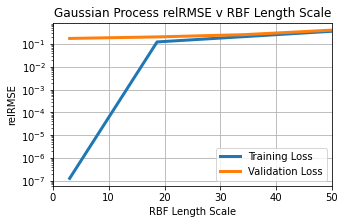

In [6]:
plt.figure(figsize = (5,3))
plt.plot(length_scale_sweep,train_loss,label = 'Training Loss',linewidth = 3)
plt.plot(length_scale_sweep,val_loss,label = 'Validation Loss',linewidth = 3)
#plt.xscale('log')
plt.yscale('log')
plt.xlim([0,max(length_scale_sweep)])
plt.grid()
plt.title('Gaussian Process relRMSE v RBF Length Scale')
plt.xlabel('RBF Length Scale')
plt.ylabel('relRMSE')

plt.legend()
best_val = length_scale_sweep[val_loss == min(val_loss)]
print(f'Best Val:{min(val_loss)}, at length scale:{best_val}')
figSaver.save(filename = 'RBF_Length_scale_error')

array([223.])

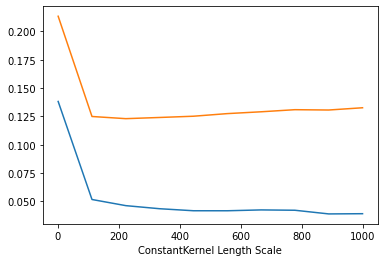

In [8]:
ConstVals = np.linspace(60,200,10)

train_loss = []
val_loss = []

for ConstVal in ConstVals:
    kernel = ConstantKernel(ConstVal, constant_value_bounds="fixed") * RBF(40, length_scale_bounds="fixed")

    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))

plt.figure()
plt.plot(ConstVals,train_loss,label = 'Training Loss')
plt.plot(ConstVals,val_loss,label = 'Validation Loss')
plt.xlabel('ConstantKernel Length Scale')
ConstVals[val_loss == min(val_loss)]

In [9]:
kernel = ConstantKernel(100, constant_value_bounds="fixed") * RBF(40, length_scale_bounds="fixed")
std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

print(score(std_gp,train_params,train_fields))
print(score(std_gp,val_params,val_fields))

0.16932986587148283
0.21995165236830014


In [ ]:
from matplotlib.colors import LogNorm
train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=0.07)
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))



gp =  GaussianProcessRegressor(kernel = kernel, normalize_y=True)

dims = (10,10)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
const_scales = np.logspace(0.01, 1.1, num=dims[0], base=10)-1
RBF_scales = np.logspace(0.01,  1.1, num=dims[1], base=10)-1
const_scales, RBF_scales = np.meshgrid(const_scales, RBF_scales)


score_grid = np.array([])

for const_scale,RBF_scale in zip(const_scales.flatten(),RBF_scales.flatten()):

    
    kernel = ConstantKernel(const_scale, constant_value_bounds="fixed") * RBF(RBF_scale,length_scale_bounds="fixed")
    gp =  GaussianProcessRegressor(kernel = kernel, normalize_y=True)

    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Const:{const_scale}, Length Scale: {RBF_scale}, Score: {iter_score}')

score_grid = score_grid.reshape(dims)

In [ ]:
from matplotlib import ticker, cm
from ssapp.Utils import FigureSaver



fig,ax=plt.subplots(1,1)
print(score_grid.min()+0.5)
norm = cm.colors.Normalize(vmax=abs(score_grid).max(), vmin=-abs(score_grid).max())

cp = ax.contourf(const_scales,RBF_scales,score_grid*100,levels = 20,locator=ticker.LogLocator(subs = [0.5,1,2,4]))
cb = fig.colorbar(cp)
cb.set_label('Validation relRMSE [%]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(1,c='r',linestyle = '--')
ax.set_xlabel("Constant Value, $\sigma_0$")
ax.set_ylabel("Length Scale, $l$")
ax.set_title("Validation Error Contour for GP with RBF Kernel")
plt.tight_layout()
plt.show()
figSaver.save(filename = 'ValidationErrorContourPlot_RBF')

In [ ]:

from matplotlib.colors import LogNorm
train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=0.07)
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))



gp =  GaussianProcessRegressor(kernel = kernel, normalize_y=True)

dims = (10,10)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
length_scales = np.logspace(0.1, 1.5, num=dims[0], base=10)-1
Nu_scales = np.logspace(0.1,  1.5, num=dims[1], base=10)-1
length_scales, Nu_scales = np.meshgrid(length_scales, Nu_scales)


score_grid = np.array([])

for length_scale,Nu_scale in zip(length_scales.flatten(),Nu_scales.flatten()):

    
    kernel = ConstantKernel(1, constant_value_bounds="fixed") * Matern(length_scale=length_scale,length_scale_bounds='fixed',nu=Nu_scale)

    gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Length Scale:{length_scale}, Nu: {Nu_scale}, Score: {iter_score}')

score_grid = score_grid.reshape(dims)

In [ ]:

fig,ax=plt.subplots(1,1)
print(score_grid.min()+0.5)
norm = cm.colors.Normalize(vmax=abs(score_grid).max(), vmin=-abs(score_grid).max())

cp = ax.contourf(Nu_scales,length_scales,score_grid*100,levels = 20,locator=ticker.LogLocator(subs = [0.5,1,2]))
cb = fig.colorbar(cp)
cb.set_label('Validation relRMSE [%]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r" $ \nu$")
ax.set_ylabel("Length Scale, $l$")
ax.set_title("Validation Error Contour for GP with Matern Kernel")





ind = np.unravel_index(np.argmin(score_grid, axis=None), score_grid.shape)

best_length_scale = length_scales[ind]
best_Nu_scales = Nu_scales[ind]
ax.scatter(best_Nu_scales,best_length_scale,marker = 'x',c='r')
ax.annotate(f'Best Error: {100*score_grid[ind]:.3f}%', (best_Nu_scales+0.2,best_length_scale),c='w')
plt.tight_layout()
plt.show()

figSaver.save(filename = 'ValidationErrorContourPlot_Matern')

In [ ]:
kernel = ConstantKernel(1, constant_value_bounds="fixed") * Matern(length_scale=best_length_scale,length_scale_bounds='fixed',nu=best_Nu_scales)

gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
iter_score = score(gp,val_params,val_fields)
score_grid = np.append(score_grid,iter_score)
print(f'Length Scale:{best_length_scale}, Nu: {best_Nu_scales}, Score: {iter_score}')

In [ ]:
dims = (5,5)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
length_scales = np.linspace(0.4, 1.5, num=dims[0])
Nu_scales = np.linspace(5,  10, num=dims[1])
length_scales, Nu_scales = np.meshgrid(length_scales, Nu_scales)


score_grid = np.array([])

for length_scale,Nu_scale in zip(length_scales.flatten(),Nu_scales.flatten()):

    
    kernel = ConstantKernel(1, constant_value_bounds="fixed") * Matern(length_scale=length_scale,length_scale_bounds='fixed',nu=Nu_scale)

    gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Length Scale:{length_scale}, Nu: {Nu_scale}, Score: {iter_score}')


score_grid = score_grid.reshape(dims)


In [ ]:
fig,ax=plt.subplots(1,1)
print(score_grid.min()+0.5)
norm = cm.colors.Normalize(vmax=abs(score_grid).max(), vmin=-abs(score_grid).max())

cp = ax.contourf(Nu_scales,length_scales,score_grid*100,levels = 20,locator=ticker.LogLocator(subs = [0.5,1,2]))
cb = fig.colorbar(cp)
cb.set_label('Validation relRMSE [%]')

ax.set_xlabel(r" $ \nu$")
ax.set_ylabel("Length Scale, $l$")
ax.set_title("Validation Error Contour for GP with Matern Kernel")

figSaver.save(filename = 'ValidationErrorContourPlot_Matern')



ind = np.unravel_index(np.argmin(score_grid, axis=None), score_grid.shape)

best_length_scale = length_scales[ind]
best_Nu_scales = Nu_scales[ind]
ax.scatter(best_Nu_scales,best_length_scale,marker = 'x',c='r')

plt.tight_layout()
plt.show()

In [ ]:
def runge_